In [2]:
import os
import pandas as pd
from skimage.io import imread
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
def masks_as_image(in_mask_list):
    '''
    Take the individual ship masks and create a single mask array for all ships
    '''
    all_masks = np.zeros(IMG_SIZE, dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

# https://github.com/ternaus/TernausNet/blob/master/Example.ipynb
def mask_overlay(image, mask):
    """
    Helper function to visualize mask
    """
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.75, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [4]:
DATA_PATH   = '../input/airbus-ship-detection/'
TRAIN_PATH  = DATA_PATH+'train_v2/'
TEST_PATH   = DATA_PATH+'test_v2/'

## The directories contain roughly 192,556  and 15606 images each.

In [5]:
train = os.listdir(TRAIN_PATH)
test = os.listdir(TEST_PATH)
print(len(train), len(test))

192556 15606


## The first thing we can do is to open and display some of the images from whitin Jupyter notebook itself.

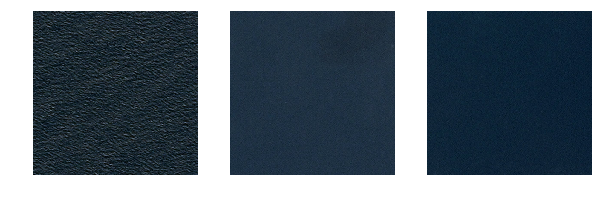

In [6]:
images = []
for ImageId in train[43:46]:
    image = imread(TRAIN_PATH+ImageId)
    images += [image]
display(images)

## We need to detection ship in this images. lets plotting ship count.

In [7]:
df = pd.read_csv(DATA_PATH+'train_ship_segmentations_v2.csv')

count    231723.000000
mean          1.344472
std           2.755929
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: ship_count, dtype: float64


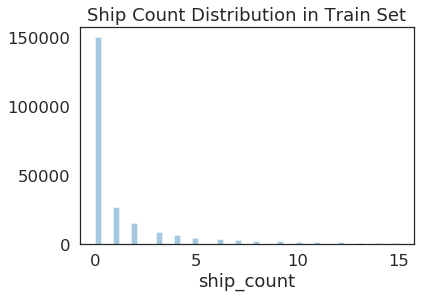

In [8]:
df = df.reset_index()
df['ship_count'] = df.groupby('ImageId')['ImageId'].transform('count')
df.loc[df['EncodedPixels'].isnull().values,'ship_count'] = 0  #see infocusp's comment

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.distplot(df['ship_count'],kde=False)
plt.title('Ship Count Distribution in Train Set')

print(df['ship_count'].describe())

# **Look at class balance**

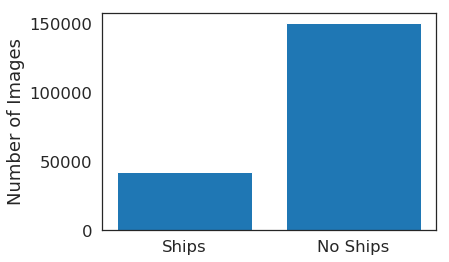

In [9]:
plt.bar(
    ['Ships', 'No Ships'], 
    [len(df[~df.EncodedPixels.isna()].ImageId.unique()),
    len(df[df.EncodedPixels.isna()].ImageId.unique())]);
plt.ylabel('Number of Images');

# Counting pixels: verifying the class imbalance between ship and no-ship pixels

The Challenge of detecting the ships in the images can be thought as a classification problem for pixels, where, for each image, we need to classify 768  ×  768 pixels in one of two classes: ship and no-ship. 

Lets present the imbalance of the classes considering a pixel-level granularity, this is, we will check how many pixels in the dataset corresponds to ships and how many to other stuff (no-ships).

In [12]:
# This function transforms EncodedPixels into a list of pixels
# Check our previous notebook for a detailed explanation:
# https://www.kaggle.com/julian3833/2-understanding-and-plotting-rle-bounding-boxes
def rle_to_pixels(rle_code):
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1:-2:2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

def show_pixels_distribution(df):
    """
    Prints the amount of ship and no-ship pixels in the df
    """
    # Total images in the df
    n_images = df['ImageId'].nunique() 
    
    # Total pixels in the df
    total_pixels = n_images * 768 * 768 

    # Keep only rows with RLE boxes, transform them into list of pixels, sum the lengths of those lists
    ship_pixels = df['EncodedPixels'].dropna().apply(rle_to_pixels).str.len().sum() 

    ratio = ship_pixels / total_pixels
    print(f"Ship: {round(ratio, 3)} ({ship_pixels})")
    print(f"No ship: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")
df = pd.read_csv(DATA_PATH+"train_ship_segmentations_v2.csv").append(pd.read_csv(DATA_PATH+"sample_submission_v2.csv"))
show_pixels_distribution(df)

Ship: 0.001 (127777104)
No ship: 0.999 (122651166384)


As you can see above, only 1‰ of the pixels are ships, while 99.9% of the pixels are no-ships.

And, as you can see below, dropping all the images with no ships in them the class imbalance is reduced, but it's still very high: 5‰, this is, 0.5% of the pixels are ships while 99.5% are no-ships.

As we will analyse in detail on the following notebook of the series, this extreme class imbalance condition of the dataset will trigger actions in the construction of the public models (in particular, the stack of a ship/no-ship image classifier for the general problem with a ship/no-ship image segmentation for only the 22% of the images with ships).

In [ ]:
show_pixels_distribution(df.dropna())